# Esercizio DBSCAN  

## Dati:


fonte: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

Margarida G. M. S. Cardoso, margarida.cardoso '@' iscte.pt, ISCTE-IUL, Lisbon, Portugal


Data Set Information:

Attribute Information:

    1) FRESH: annual spending (m.u.) on fresh products (Continuous);
    2) MILK: annual spending (m.u.) on milk products (Continuous);
    3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
    4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
    5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
    6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
    7) CHANNEL: customers  Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
    8) REGION: customers  Region Lisnon, Oporto or Other (Nominal)
 

Relevant Papers:

Cardoso, Margarida G.M.S. (2013). Logical discriminant models â€“ Chapter 8 in Quantitative Modeling in Marketing and Management Edited by Luiz Moutinho and Kun-Huang Huarng. World Scientific. p. 223-253. ISBN 978-9814407717

Jean-Patrick Baudry, Margarida Cardoso, Gilles Celeux, Maria JosÃ© Amorim, Ana Sousa Ferreira (2012). Enhancing the selection of a model-based clustering with external qualitative variables. RESEARCH REPORT NÂ° 8124, October 2012, Project-Team SELECT. INRIA Saclay - ÃŽle-de-France, Projet select, UniversitÃ© Paris-Sud 11



-----

## DBSCAN e Clustering 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/pg-88/IFOA_ML_AI/main/Risorse/dataset/wholesome-customers-data.csv')

In [7]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


## EDA


<Axes: >

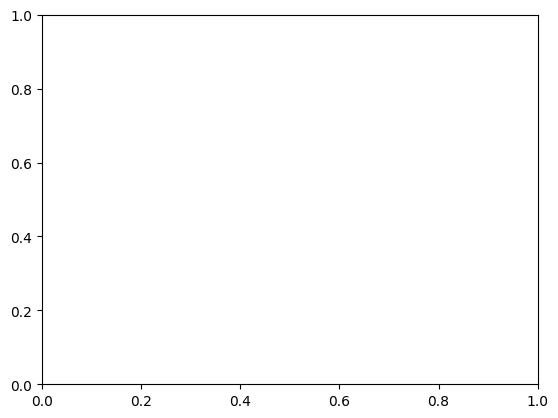

In [4]:
# latte - alimentari in funzione del canale di vendita 

sns.scatterplot()

In [ ]:
## istogramma con le vendite del latte per canale di vendita

**clustermap della correlazione tra categorie di spesa.**

In [85]:
#

**PairPlot odel dataframe, colorato per Regione.**

In [ ]:
#CODE HERE

## DBSCAN

Partiamo scalando i valori

In [87]:
#

**Ciclo per determinare il valore migliore di epsilon**

il valore di n lo poniamo pari al doppio del numero di feature

il range di valori per epsilon sarà:

    np.linspace(0.001,3,50)

In [95]:
#

**Creare un line plot della percentuale di outliers in funzione della epsilon scelta.**

In [98]:
#

## DBSCAN con la epsilon scelta

**Creare il modello con il valore che cu sembra più appropriato**

In [5]:
# 

**scatterplot di grocery e milk colorati in funzione delle label trovate**

In [127]:
#

**scatterplot di Milk vs. Detergents Paper colorate in funzione delle label.**

In [133]:
#

**comparare la media delle varie categorie per ciascuna label e per gli outliers**

In [109]:
# 

----